# Introduction to Machine Learning, UZH 2018, Group Project
### Group 2: Barbara Capl, Mathias Lüthi, Pamela Matias, Stefanie Rentsch
##       
# 2b. Feature Extraction with Principal Component Analysis (PCA)

In this section we use the feature matrices and the response vector that we prepared in chapter 1.  

#### We use two different versions (created in chapter 1):
Version 1: Feature Matrix consists only of the Ratios                                                                        
Version 2: Feature Matrix consists of Ratios + dummy variables for seasonality + other market data
####     


In [1]:
# hide unnecessary warnings ("depreciation" of packages etc.)
import warnings
warnings.filterwarnings('ignore')

# import packages
import numpy as np
import pandas as pd
import matplotlib as pl
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn as skl
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

## 2.0. Choose which Feature Matrix (Version 1 or 2) you want to load in by choosing the Case

#### 1) Choose the Dataset Version you want
VERSION = 1; Feature Matrix with only ratios                                  
VERSION = 2;  Feature Matrix with ratios + saisonality + other market data


In [17]:
### Chose which dataset version you want the selection of features and the prediction to be based on 
VERSION = 2
"""
INSERT NUMBER 1 or 2
"""


# Define sel_state variable for easier printing out    
if VERSION == 1:
    sel_version = 'Based on Dataset with only the Ratios Dataset as predicive Features'
elif VERSION == 2:
    sel_version = 'Based on Dataset with Ratios + Seasonality + other Market Data as predictive Features'
else: raise ValueError('VERSION must be either 1 or 2')

## 2.1. Preparation


### 2.1.1 Import the Response Vector and the Feature Matrices

In [3]:
# Load in the response vector 
y = pd.read_csv('Data/generated_datasets/response_1.csv', sep=',', header=0)

In [4]:
if VERSION == 1:
    X = pd.read_csv('Data/generated_datasets/features_ratios_1.csv', sep=',', header=0)
elif VERSION == 2:
    X = pd.read_csv('Data/generated_datasets/features_additional_1.csv', sep=',', header=0)
else: raise ValueError('VERSION value must be either 1 or 2')

### 2.1.2. Train/ Test Split, fill missing values with median and standardize

### Train/ Test Split

In [5]:
# Train/test split, into 20% test size and 80% train size because it is a relatively small dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Extract the feature labels
feature_labels = list(X)
print('Type of feature_labels = ' + str(type(feature_labels)))
print("")

Type of feature_labels = <class 'list'>



### Fill missing values

In [6]:
# Use a median fill for train
imp = Imputer(missing_values=np.nan, strategy = 'median' , axis=0)
imputed_dataset = pd.DataFrame(imp.fit_transform(X_train))
imputed_dataset.columns = X_train.columns
imputed_dataset.index = X_train.index
X_train = imputed_dataset

# Use a median fill for the test set
imputed_dataset = pd.DataFrame(imp.fit_transform(X_test))
imputed_dataset.columns = X_test.columns
imputed_dataset.index = X_test.index
X_test = imputed_dataset

### Standardize

In [7]:
# Standardization with sklearn StandardScaler
standard_scaler = preprocessing.StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

  
## 2.2. Run PCA on whole Training Set for all possible PCAs (= number of columns)

### 2.2.1.  Generate PCA object and show plots

In [8]:
# Run PCA for all possible PCAs
pca_a = PCA().fit(X_train)

# Define maximal number of principal components => the "1" in shape[1] refers to columns ("0" would be rows)
q_a = X_train.shape[1]

# Get the amount of variance that each PC explains
# The eigenvalues represent the variance in the direction of the eigenvector
# These numbers for each component are proportional to the Eigenvalues 
# This means that the ratio of the eigenvalue of the first principal component 
# to the eigenvalue of the second principal component is 0.16214649
# SEE => https://stackoverflow.com/questions/37757172/finding-and-utilizing-eigenvalues-and-eigenvectors-from-pca-in-scikit-learn?rpca.q=1
expl_var_a = pca_a.explained_variance_ratio_

# Get cumulative sum of the PCA 1-q_a
sum_expl_var_a = np.cumsum(expl_var_a)[:q_a]

# because we run PCA for all possible PCAs, sum of al explained Variance of the training set should be 1

print("")
print('Explained Variance, first 10 rows: ')
print(expl_var_a[0:10])
print("")
print('Explained Variance in Total = ' + str(expl_var_a.sum()))
print("")
print('Cumulative explained Variance, first 10 rows: ')
print(sum_expl_var_a[0:10])
print("")
print('Maximal number (q_a) of PCs is: ' + str(q_a))
print("")


Explained Variance, first 10 rows: 
[0.20578405 0.13680895 0.0757929  0.05987882 0.04687191 0.04132596
 0.03515177 0.03286437 0.03234243 0.02745725]

Explained Variance in Total = 0.9999999999999999

Cumulative explained Variance, first 10 rows: 
[0.20578405 0.342593   0.4183859  0.47826473 0.52513663 0.5664626
 0.60161437 0.63447874 0.66682117 0.69427841]

Maximal number (q_a) of PCs is: 71



### 2.2.2.  Plot cumulative explained variace

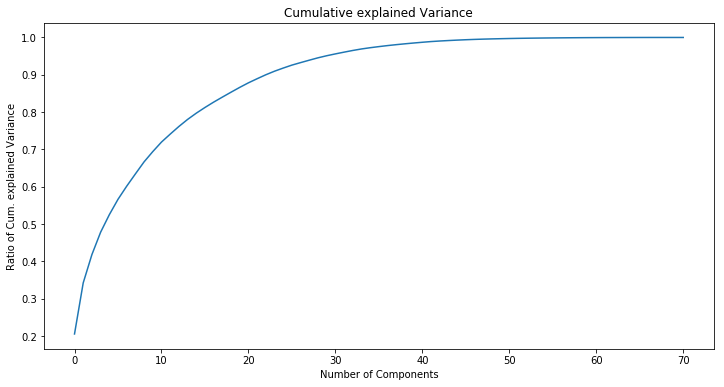

In [9]:
# Plot curve with cumulative sum
plt.figure(figsize = (12, 6))
plt.plot(sum_expl_var_a)
plt.title('Cumulative explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Cum. explained Variance')
plt.xticks(range(0, q_a + 1, 10))
plt.show();

### 2.1.2  Plot explained variance by single components

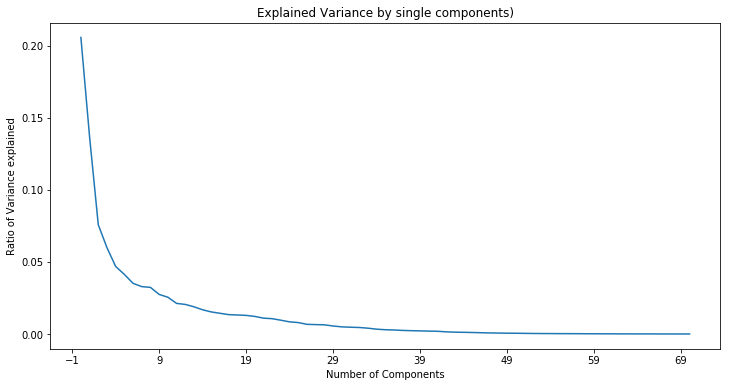

In [10]:
# Plot curve with explained variance
plt.figure(figsize = (12, 6))
plt.plot(expl_var_a)
plt.title('Explained Variance by single components)')
plt.xlabel('Number of Components')
plt.ylabel('Ratio of Variance explained')
plt.xticks(range(-1, q_a + 1, 10))
plt.show();

### 2.1.3 Plot feature importances

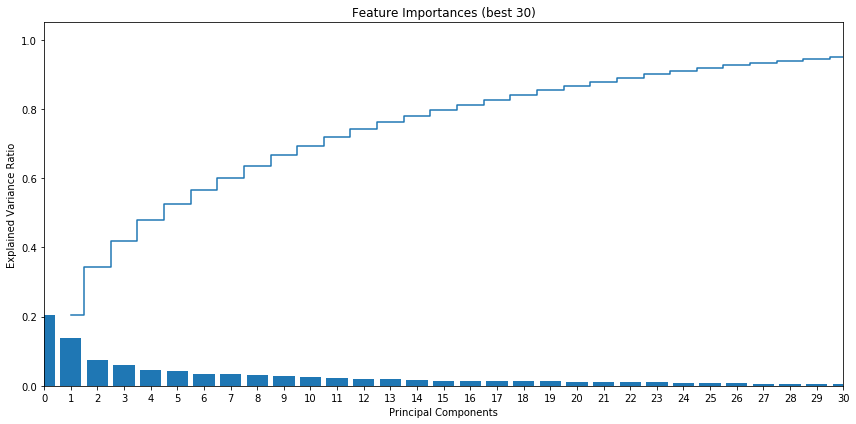

In [11]:
# Plot Feature Importances (both cumulative and idividual)
plt.figure(figsize = (12, 6))
plt.title('Feature Importances (best 30)')
plt.bar(range(0, q_a), expl_var_a, align = 'center')
plt.xticks(range(0, q_a + 1, 1))
plt.xlim([0, 30])
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.step(range(1, q_a + 1), sum_expl_var_a, where = 'mid')
plt.tight_layout();

## 2.3.  Run PCA on whole Training Set for selected number 'q' of PCAs

### 2.2.1. Choose number of Principal Components  and get them for further use

In [12]:
# Define number of principal components we wish to extract
q = 10

# Create PCA object
pca = PCA(n_components = q)

# Fit PCA object to find first principal components
pca.fit(X_train)

print('PCA Object; ' + str(pca))

# Get the amount of variance that each PC explains
# The eigenvalues represent the variance in the direction of the eigenvector
# These numbers for each component are proportional to the Eigenvalues 
# This means that the ratio of the eigenvalue of the first principal component 
# to the eigenvalue of the second principal component is 0.16214649
# SEE => https://stackoverflow.com/questions/37757172/finding-and-utilizing-eigenvalues-and-eigenvectors-from-pca-in-scikit-learn?rpca.q=1
expl_var = pca.explained_variance_ratio_

# Get cumulative sum of the PCA 1-q_1
sum_expl_var = np.cumsum(expl_var)[:q]

# because we run PCA for only q_1 components, sum of al explained Variance of the training set should be LESS than 1

print("")
print('Explained Variance, first 10 rows: ')
print(expl_var[0:10])
print("")
print('Explained Variance in Total = ' + str(expl_var.sum()))
print("")
print('Cumulative explained Variance, first 10 rows: ')
print(sum_expl_var[0:10])
print("")
print("")

PCA Object; PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Explained Variance, first 10 rows: 
[0.20578405 0.13680895 0.0757929  0.05987879 0.04687181 0.04132539
 0.0351502  0.03285114 0.03233813 0.02745138]

Explained Variance in Total = 0.6942527430423306

Cumulative explained Variance, first 10 rows: 
[0.20578405 0.342593   0.4183859  0.47826469 0.52513651 0.5664619
 0.60161209 0.63446324 0.66680137 0.69425274]




### 2.2.2.  Extract q_1 /q_2 number of features out of Training Set; Transform feature matrix with pca object

In [13]:
# Extract q number of features according to pca analysis
# WEBSITE => https://www.analyticsvidhya.com/blog/2016/03/practical-guide-principal-component-analysis-python/
X_train_transformed = pca.fit_transform(X_train)

# display properties
display(X_train_transformed)
len(X_train_transformed)
display(X_train_transformed.shape)
display(X_train.shape)

# This gives the Eigenvalues?

array([[-1.99247604, -3.85416276, -1.35808507, ..., -1.01555337,
        -0.43618298, -1.12293995],
       [ 3.62335838,  1.68860044, -3.63177749, ..., -0.42787021,
         0.27010388, -0.19130977],
       [ 3.97035236, -6.46917603,  0.33615876, ..., -0.39588451,
         1.36945403,  0.20055708],
       ...,
       [-3.54799462, -2.11626978,  0.23014679, ..., -0.19817632,
        -0.74629309, -0.5424661 ],
       [ 4.12163602, -2.27427451,  1.80867317, ..., -0.48352313,
        -1.02232512,  0.48639424],
       [-4.35305237, -1.50040167, -0.84342652, ..., -0.19024995,
         1.13705974, -1.25613879]])

(2836, 10)

(2836, 71)

### 2.2.3. Transform new data (Test set) using the already fitted pca object and save the resulting feature matrices

### Transform the Test Feature Matrix and create pandas dataframe

In [14]:
# Goal: Test Set has the same features as training set
X_train_transformed = pca.fit_transform(X_train)
X_test_transformed = pca.transform(X_test)

# Put the X Sets into a pandas dataframe (they are numpy)
X_train_p = pd.DataFrame(X_train_transformed)
X_test_p = pd.DataFrame(X_test_transformed)  

### Save PCA- transformed Fature Matrices and the Respose Vector

In [15]:
if VERSION == 1:
    X_train_p.to_csv('Data/generated_splits/features_selected_pca/X1_train_p.csv', index = False)
    X_test_p.to_csv('Data/generated_splits/features_selected_pca/X1_test_p.csv', index = False)
    y_train.to_csv('Data/generated_splits/features_selected_pca/y1_train_p.csv', index = False)
    y_test.to_csv('Data/generated_splits/features_selected_pca/y1_test_p.csv', index = False)
elif VERSION == 2:
    X_train_p.to_csv('Data/generated_splits/features_selected_pca/X2_train_p.csv', index = False)
    X_test_p.to_csv('Data/generated_splits/features_selected_pca/X2_test_p.csv', index = False)
    y_train.to_csv('Data/generated_splits/features_selected_pca/y2_train_p.csv', index = False)
    y_test.to_csv('Data/generated_splits/features_selected_pca/y2_test_p.csv', index = False)
else: raise ValueError('VERSION value must be either 1 or 2')